In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from collections import Counter
from datetime import datetime
import re

#%matplotlib inline
pd.set_option('display.max_columns', 100)

In [46]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

#### Helper Functions

In [47]:
def label_encoding_func(df_name, df_col_name):
    '''
    usage: dataframe[column_name] = label_encoding_function(dataframe, column_name)
    '''
    le = preprocessing.LabelEncoder()
    le.fit(df_name[df_col_name])
    return le.transform(df_name[df_col_name])

In [48]:
def do_one_hot_encoding(df_name, df_column_name, suffix=''):
    '''
    usage: dataframe[column_name] = do_one_hot_encoding(dataframe, column_name, suffix_for_column_name)
    '''
    x = pd.get_dummies(df_name[df_column_name])
    df_name = df_name.join(x, lsuffix=suffix)
    df_name = df_name.drop(df_column_name, axis=1) 
    return df_name

#### Load and Process Data

In [49]:
train_df = pd.read_csv('train_aox2Jxw/train.csv')
test_df = pd.read_csv('test_bqCt9Pv.csv')

In [50]:
train_df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [51]:
test_df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


In [52]:
X_train = train_df.copy()
X_test = test_df.copy()
X_test['loan_default'] = 0
Y = train_df['loan_default']

In [53]:
concat_df = pd.concat([X_train, X_test], keys=['train', 'test'])

### Data Distributions

##### Disbursed Amount

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


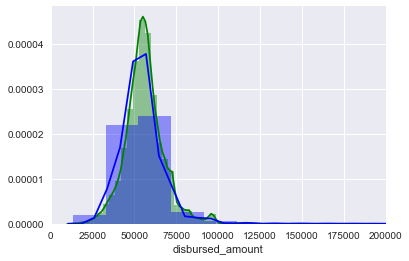

In [54]:
sns.distplot(train_df[train_df['loan_default']==1]['disbursed_amount'], color='green')
sns.distplot(train_df[train_df['loan_default']==0]['disbursed_amount'], color='blue')
plt.rcParams["figure.figsize"] = (12,8)
plt.xlim([0, 200000])
plt.show()

##### LTV

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


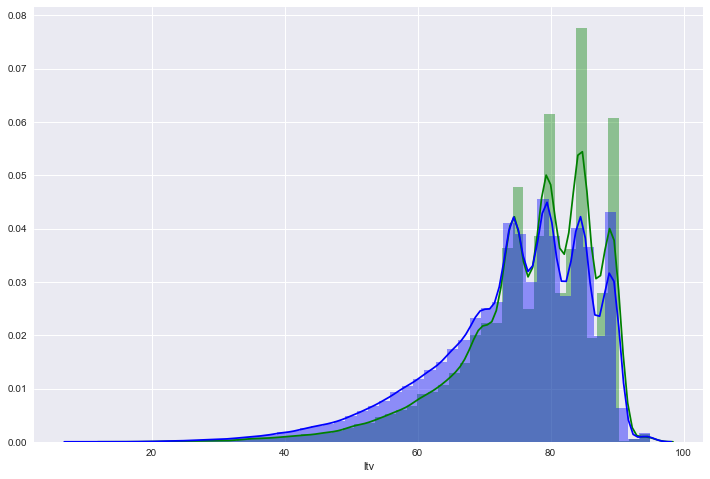

In [55]:
sns.distplot(train_df[train_df['loan_default']==1]['ltv'], color='green')
sns.distplot(train_df[train_df['loan_default']==0]['ltv'], color='blue')
plt.rcParams["figure.figsize"] = (12,8)
plt.show()

##### Distinct value counts for all variables

In [56]:
unique_value_counts = []

for i in concat_df.columns.values:
    unique_value_counts.append(len(concat_df[i].value_counts()))
    
    
unique_values_df = pd.DataFrame({
    'cols': concat_df.columns.values,
    'unique_values': unique_value_counts
}).sort_values('unique_values')

unique_values_df

,cols,unique_values
13,MobileNo_Avl_Flag,1
40,loan_default,2
18,Passport_flag,2
17,Driving_flag,2
16,VoterID_flag,2
15,PAN_flag,2
14,Aadhar_flag,2
9,Employment.Type,2
29,SEC.OVERDUE.ACCTS,9
6,manufacturer_id,12


##### Comparison between means of values of variables between target = 1 and target = 0 and between test and train

In [57]:
### prepare arrays containing specific column types

dtypes_df = train_df.dtypes.reset_index()

numeric_cols = dtypes_df[(dtypes_df[0] != object) & (dtypes_df['index'] != 'UniqueID') & 
          (dtypes_df['index'] != 'loan_default')]['index'].values

greater_than_2_distinct_values = unique_values_df[unique_values_df['unique_values'] > 2]['cols'].values
non_categorical_numeric_columns = [i for i in numeric_cols if i in greater_than_2_distinct_values]

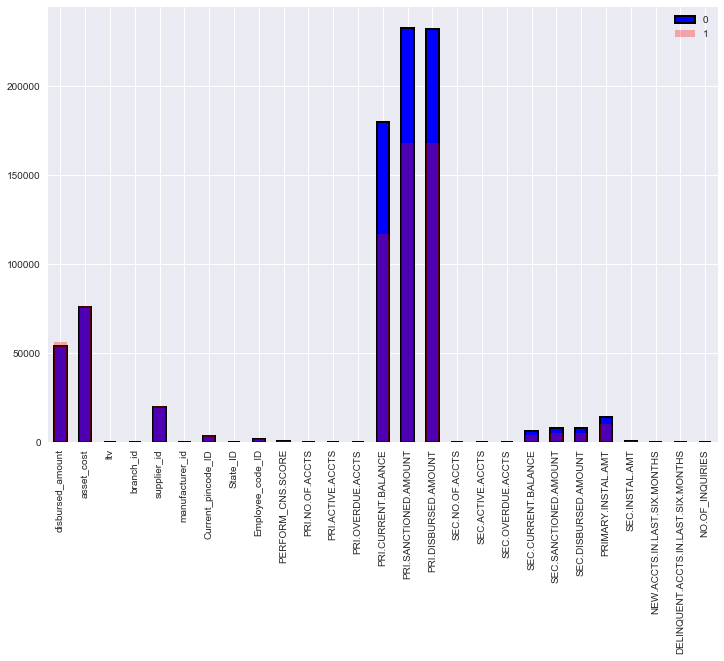

In [58]:
train_df[train_df['loan_default']==0][non_categorical_numeric_columns].mean(axis=0).plot(kind='bar', 
                                                                        label='0', color='blue',
                                                                        linewidth=2, edgecolor='k') 
                                                         
train_df[train_df['loan_default']==1][non_categorical_numeric_columns].mean(axis=0).plot(kind='bar', 
                                                                label='1', color='red', alpha=0.3) 
plt.rcParams["figure.figsize"] = (16,7)
plt.legend()
plt.show()

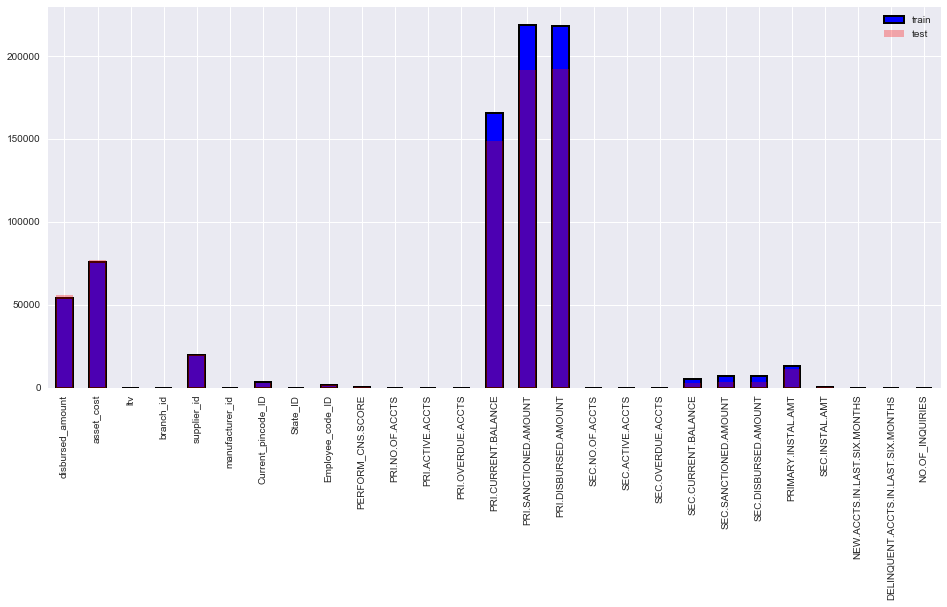

In [59]:
train_df[non_categorical_numeric_columns].mean(axis=0).plot(kind='bar', label='train', color='blue', 
                                                           linewidth=2, edgecolor='k') 
test_df[non_categorical_numeric_columns].mean(axis=0).plot(kind='bar', label='test', color='red', alpha=0.3) 
#plt.ylim(0,100000)
plt.rcParams["figure.figsize"] = (16,7)
plt.legend()
plt.show()

##### Correlation Heatmap

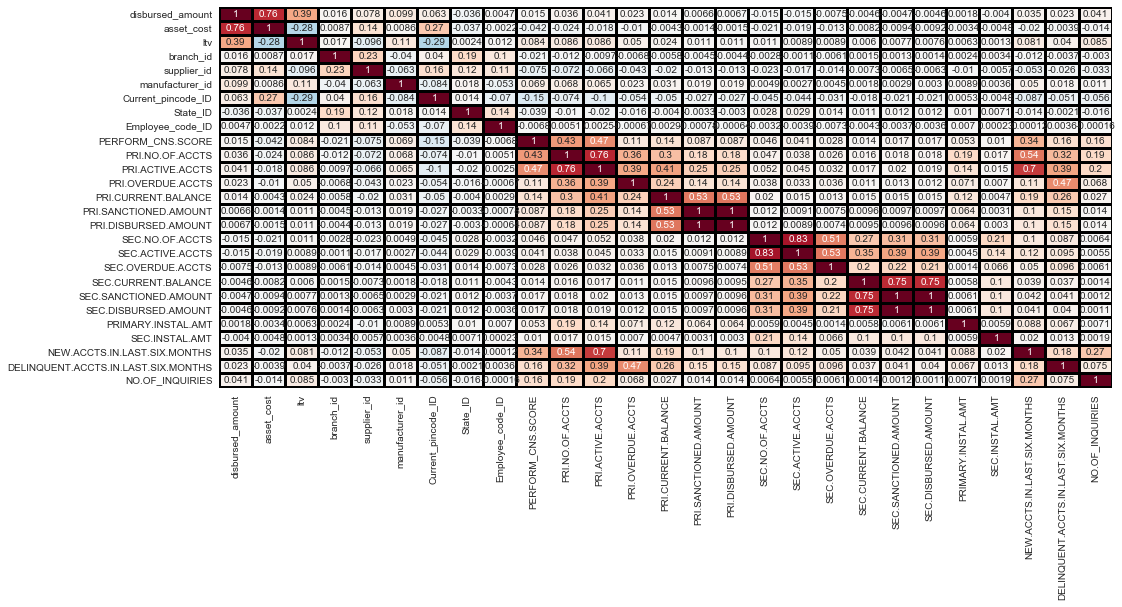

In [60]:
sns.heatmap(concat_df[non_categorical_numeric_columns].corr(), annot=True, cbar=False, linewidths=2, linecolor='k',
           robust=True)
plt.rcParams["figure.figsize"] = (20,18)
plt.show()
#plt.savefig('CorrelationPlot.png', dpi=300)

##### CNS Score

In [61]:
print("CNS Score is zero: ", sum(concat_df['PERFORM_CNS.SCORE'] == 0))

concat_df[concat_df['PERFORM_CNS.SCORE'] == 0]["PERFORM_CNS.SCORE.DESCRIPTION"].value_counts()

CNS Score is zero:  174843


No Bureau History Available    174843
Name: PERFORM_CNS.SCORE.DESCRIPTION, dtype: int64

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


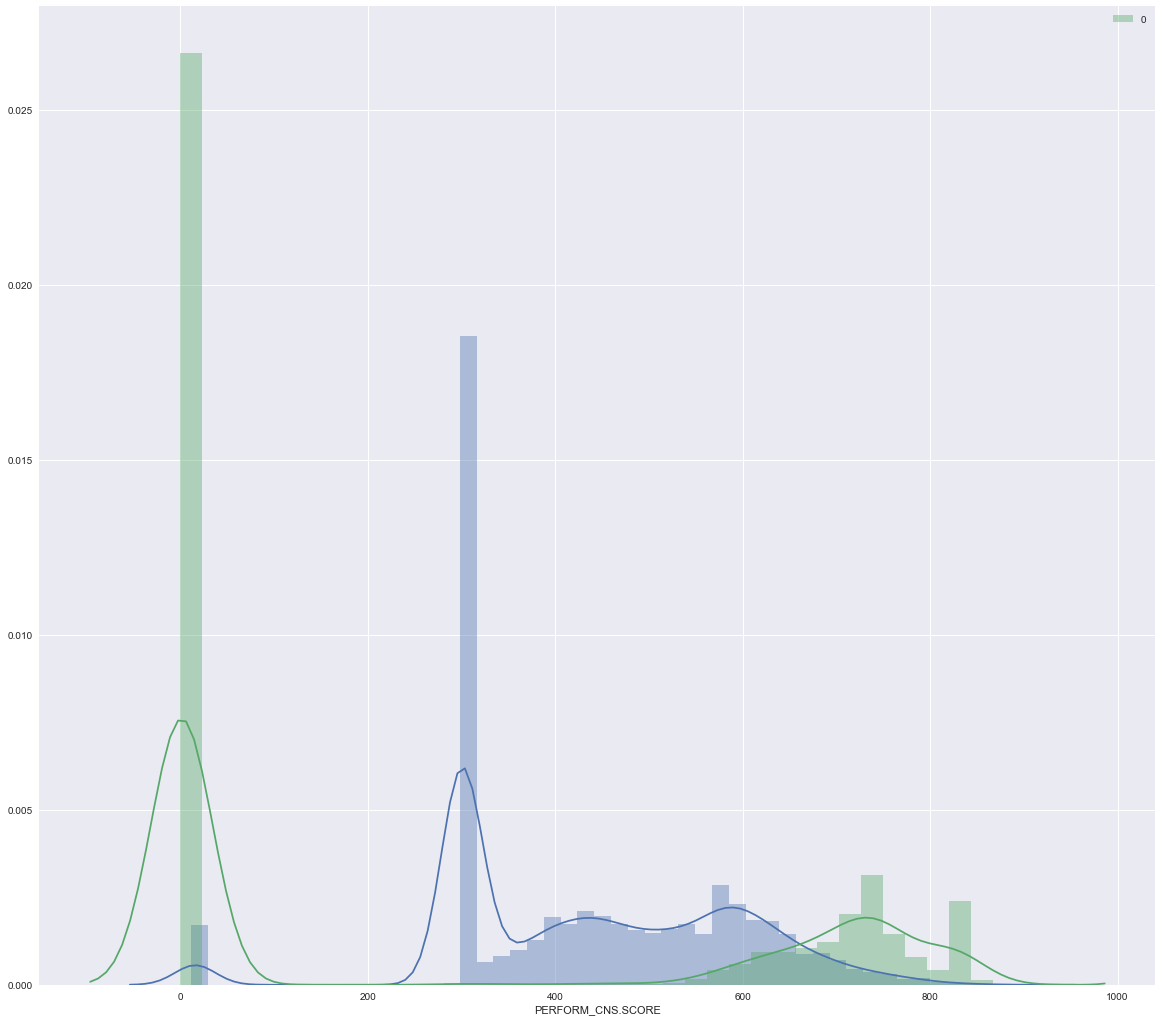

In [62]:
sns.distplot(train_df[train_df['PRI.OVERDUE.ACCTS']>0]['PERFORM_CNS.SCORE'])
sns.distplot(train_df[train_df['PRI.OVERDUE.ACCTS']==0]['PERFORM_CNS.SCORE'], label='0')
plt.legend()
plt.rcParams["figure.figsize"] = (16,8)
plt.show()

### Feature Engineering

In [63]:
concat_df.head()

UniqueID  disbursed_amount  asset_cost    ltv  branch_id  \
train 0    420825             50578       58400  89.55         67   
      1    537409             47145       65550  73.23         67   
      2    417566             53278       61360  89.63         67   
      3    624493             57513       66113  88.48         67   
      4    539055             52378       60300  88.39         67   

         supplier_id  manufacturer_id  Current_pincode_ID Date.of.Birth  \
train 0        22807               45                1441      01-01-84   
      1        22807               45                1502      31-07-85   
      2        22807               45                1497      24-08-85   
      3        22807               45                1501      30-12-93   
      4        22807               45                1495      09-12-77   

        Employment.Type DisbursalDate  State_ID  Employee_code_ID  \
train 0        Salaried      03-08-18         6              1998   
      1   Self employed      26-09-18         6              1998   
      2   Self employed      01-08-18         6              1998   
      3   Self employed      26-10-18         6              1998   
      4   Self employed      26-09-18         6              1998   

         MobileNo_Avl_Flag  Aadhar_flag  PAN_flag  VoterID_flag  Driving_flag  \
train 0                  1            1         0             0             0   
      1                  1            1         0             0             0   
      2                  1            1         0             0             0   
      3                  1            1         0             0             0   
      4                  1            1         0             0             0   

         Passport_flag  PERFORM_CNS.SCORE PERFORM_CNS.SCORE.DESCRIPTION  \
train 0              0                  0   No Bureau History Available   
      1              0                598                 I-Medium Risk   
      2              0                  0   No Bureau History Available   
      3              0                305              L-Very High Risk   
      4              0                  0   No Bureau History Available   

         PRI.NO.OF.ACCTS  PRI.ACTIVE.ACCTS  PRI.OVERDUE.ACCTS  \
train 0                0                 0                  0   
      1                1                 1                  1   
      2                0                 0                  0   
      3                3                 0                  0   
      4                0                 0                  0   

         PRI.CURRENT.BALANCE  PRI.SANCTIONED.AMOUNT  PRI.DISBURSED.AMOUNT  \
train 0                    0                      0                     0   
      1                27600                  50200                 50200   
      2                    0                      0                     0   
      3                    0                      0                     0   
      4                    0                      0                     0   

         SEC.NO.OF.ACCTS  SEC.ACTIVE.ACCTS  SEC.OVERDUE.ACCTS  \
train 0                0                 0                  0   
      1                0                 0                  0   
      2                0                 0                  0   
      3                0                 0                  0   
      4                0                 0                  0   

         SEC.CURRENT.BALANCE  SEC.SANCTIONED.AMOUNT  SEC.DISBURSED.AMOUNT  \
train 0                    0                      0                     0   
      1                    0                      0                     0   
      2                    0                      0                     0   
      3                    0                      0                     0   
      4                    0                      0                     0   

         PRIMARY.INSTAL.AMT  SEC.INSTAL.AMT  NEW.ACCTS.IN.LAST.SIX.MONTHS  \
train

#### Generating new features and extracting information from existing ones
Might Contain a lot of nulls and inf -> fix after all new features are created -> replace with 0 <br>
`Track of Columns to Drop` <br>
- Date.of.Birth_dt / Date.of.Birth
- DisbursalDate_dt / DisbursalDate
- AVERAGE.ACCT.AGE
- CREDIT.HISTORY.LENGTH

In [64]:
### manually calculate ltv by ratio of disbursed amount to asset cost
concat_df['F1_Manual_LTV'] = concat_df['disbursed_amount']/concat_df['asset_cost']*100

### difference between disbursed amount and asset cost
concat_df['F2_difference_asset_disbursed'] = concat_df['asset_cost'] - concat_df['disbursed_amount']

### average sanctioned amount primary
concat_df['F3_avg_primary_sanctioned_amt'] = concat_df['PRI.SANCTIONED.AMOUNT']/concat_df['PRI.NO.OF.ACCTS']

### average disbursed amount primary 
concat_df['F4_avg_primary_disbursed_amt'] = concat_df['PRI.DISBURSED.AMOUNT']/concat_df['PRI.NO.OF.ACCTS']

### primary overdue ratio
concat_df['F5_ratio_primary_active_overdue'] = concat_df['PRI.OVERDUE.ACCTS']/concat_df['PRI.ACTIVE.ACCTS']

<b> Dealing with DOB and Disbursed Date

In [65]:
def string_to_date(dt_str_value):
    return datetime.strptime(dt_str_value, "%d-%m-%y").date()

In [66]:
concat_df['Date.of.Birth_dt'] = concat_df['Date.of.Birth'].apply(string_to_date)

In [67]:
concat_df['DisbursalDate_dt'] = concat_df['DisbursalDate'].apply(string_to_date)

In [68]:
def get_age_at_disbursal(df):
    delta = df['DisbursalDate_dt'] - df['Date.of.Birth_dt']
    return abs(delta.days/365)

concat_df['F6_age_at_disbursal'] = concat_df.apply(get_age_at_disbursal, axis=1)

In [69]:
def extract_year_month_date(date_value):
    return date_value.year, date_value.month, date_value.day

In [70]:
concat_df['F7.1_DOB_Y'], concat_df['F7.2_DOB_M'], concat_df['F7.3_DOB_D'] = zip(*concat_df['Date.of.Birth_dt'].map(
                                                                                extract_year_month_date))

In [71]:
concat_df['F8.1_DisDate_Y'], concat_df['F8.2_DisDate_M'], concat_df['F8.3_DisDate_D'] = \
zip(*concat_df['DisbursalDate_dt'].map(extract_year_month_date))

<b> Dealing with CreditHistoryLength and AVGAccountAge

In [72]:
def extract_num_from_string(string_with_num):
    string_list = string_with_num.split(" ")
    y = re.search(r'(\d+)', string_list[0]).groups()[0]
    m = re.search(r'(\d+)', string_list[1]).groups()[0]
    
    return y, m

In [73]:
concat_df['F9.1_AVG.ACCT.AGE_Y'],concat_df['F9.2_AVG.ACCT.AGE_M'] = \
            zip(*concat_df['AVERAGE.ACCT.AGE'].map(extract_num_from_string))
    

concat_df['F10.1_CREDIT.HIST_Y'],concat_df['F10.2_CREDIT.HIST_M'] = \
            zip(*concat_df['CREDIT.HISTORY.LENGTH'].map(extract_num_from_string))

In [74]:
concat_df = concat_df.reset_index().drop('level_1', axis=1)

<b> Primary Overdue Accounts Grouped Features

In [75]:
pincode_overdue_primary = concat_df.groupby('Current_pincode_ID')['PRI.OVERDUE.ACCTS'].sum().reset_index()
state_overdue_primary = concat_df.groupby('State_ID')['PRI.OVERDUE.ACCTS'].sum().reset_index()
supplier_overdue_primary = concat_df.groupby('supplier_id')['PRI.OVERDUE.ACCTS'].sum().reset_index()
branch_overdue_primary = concat_df.groupby('branch_id')['PRI.OVERDUE.ACCTS'].sum().reset_index()

In [76]:
concat_df = pd.merge(concat_df, pincode_overdue_primary, how='left', on='Current_pincode_ID', 
         suffixes=('', '_sum_pincode_F11.1'))
concat_df = pd.merge(concat_df, state_overdue_primary, how='left', on='State_ID', 
         suffixes=('', '_sum_state_F11.2'))
concat_df = pd.merge(concat_df, supplier_overdue_primary, how='left', on='supplier_id', 
         suffixes=('', '_sum_supplier_F11.3'))
concat_df = pd.merge(concat_df, branch_overdue_primary, how='left', on='branch_id', 
         suffixes=('', '_sum_branch_F11.4'))

<b> Primary Active Accounts Grouped Features

In [77]:
pincode_active_primary = concat_df.groupby('Current_pincode_ID')['PRI.ACTIVE.ACCTS'].sum().reset_index()
state_active_primary = concat_df.groupby('State_ID')['PRI.ACTIVE.ACCTS'].sum().reset_index()
supplier_active_primary = concat_df.groupby('supplier_id')['PRI.ACTIVE.ACCTS'].sum().reset_index()
branch_active_primary = concat_df.groupby('branch_id')['PRI.ACTIVE.ACCTS'].sum().reset_index()

In [78]:
concat_df = pd.merge(concat_df, pincode_active_primary, how='left', on='Current_pincode_ID', 
         suffixes=('', '_sum_pincode_F12.1'))
concat_df = pd.merge(concat_df, state_active_primary, how='left', on='State_ID', 
         suffixes=('', '_sum_state_F12.2'))
concat_df = pd.merge(concat_df, supplier_active_primary, how='left', on='supplier_id', 
         suffixes=('', '_sum_supplier_F12.3'))
concat_df = pd.merge(concat_df, branch_active_primary, how='left', on='branch_id', 
         suffixes=('', '_sum_branch_F12.4'))

#### Avg Ltv branch and pincode

In [79]:
pincode_ltv_primary = concat_df.groupby('Current_pincode_ID')['ltv'].mean().reset_index()
branch_ltv_primary = concat_df.groupby('branch_id')['ltv'].mean().reset_index()

concat_df = pd.merge(concat_df, pincode_ltv_primary, how='left', on='Current_pincode_ID', 
         suffixes=('', '_mean_pincode_F13.1'))
concat_df = pd.merge(concat_df, branch_ltv_primary, how='left', on='branch_id', 
         suffixes=('', '_mean_branch_F13.2'))

In [80]:
concat_df['ltv_mean_pincode_F13.1'] = round(concat_df['ltv_mean_pincode_F13.1'], 2)
concat_df['ltv_mean_branch_F13.2'] = round(concat_df['ltv_mean_branch_F13.2'], 2)

<b> Average PRI.CURRENT.BALANCE based on pincode and branch

In [81]:
pincode_pri_current_bal = concat_df.groupby('Current_pincode_ID')['PRI.CURRENT.BALANCE'].mean().reset_index()
branch_pri_current_bal = concat_df.groupby('branch_id')['PRI.CURRENT.BALANCE'].mean().reset_index()

concat_df = pd.merge(concat_df, pincode_pri_current_bal, how='left', on='Current_pincode_ID', 
         suffixes=('', '_mean_pincode_F14.1'))
concat_df = pd.merge(concat_df, branch_pri_current_bal, how='left', on='branch_id', 
         suffixes=('', '_mean_branch_F14.2'))

In [82]:
concat_df['PRI.CURRENT.BALANCE_mean_pincode_F14.1'] = concat_df['PRI.CURRENT.BALANCE_mean_pincode_F14.1'].apply(int)
concat_df['PRI.CURRENT.BALANCE_mean_branch_F14.2'] = concat_df['PRI.CURRENT.BALANCE_mean_branch_F14.2'].apply(int)

#### View Sample of all newly created variables

In [83]:
concat_df.head()

,level_0,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,F1_Manual_LTV,F2_difference_asset_disbursed,F3_avg_primary_sanctioned_amt,F4_avg_primary_disbursed_amt,F5_ratio_primary_active_overdue,Date.of.Birth_dt,DisbursalDate_dt,F6_age_at_disbursal,F7.1_DOB_Y,F7.2_DOB_M,F7.3_DOB_D,F8.1_DisDate_Y,F8.2_DisDate_M,F8.3_DisDate_D,F9.1_AVG.ACCT.AGE_Y,F9.2_AVG.ACCT.AGE_M,F10.1_CREDIT.HIST_Y,F10.2_CREDIT.HIST_M,PRI.OVERDUE.ACCTS_sum_pincode_F11.1,PRI.OVERDUE.ACCTS_sum_state_F11.2,PRI.OVERDUE.ACCTS_sum_supplier_F11.3,PRI.OVERDUE.ACCTS_sum_branch_F11.4,PRI.ACTIVE.ACCTS_sum_pincode_F12.1,PRI.ACTIVE.ACCTS_sum_state_F12.2,PRI.ACTIVE.ACCTS_sum_supplier_F12.3,PRI.ACTIVE.ACCTS_sum_branch_F12.4,ltv_mean_pincode_F13.1,ltv_mean_branch_F13.2,PRI.CURRENT.BALANCE_mean_pincode_F14.1,PRI.CURRENT.BALANCE_mean_branch_F14.2
0,train,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,86.606164,7822,NaN,NaN,NaN,1984-01-01,2018-08-03,34.610959,1984,1,1,2018,8,3,0,0,0,0,3,6902,14,1687,19,52280,88,15907,74.47,76.92,30411,220811
1,train,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,71.922197,18405,50200.0,50200.0,1.0,1985-07-31,2018-09-26,33.178082,1985,7,31,2018,9,26,1,11,1,11,2,6902,14,1687,15,52280,88,15907,79.98,76.92,508731,220811
2,train,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,86.828553,8082,NaN,NaN,NaN,1985-08-24,2018-08-01,32.958904,1985,8,24,2018,8,1,0,0,0,0,8,6902,14,1687,68,52280,88,15907,79.84,76.92,169841,220811
3,train,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1,86.991968,8600,0.0,0.0,NaN,1993-12-30,2018-10-26,24.838356,1993,12,30,2018,10,26,0,8,1,3,4,6902,14,1687,17,52280,88,15907,76.62,76.92,129546,220811
4,train,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1,86.862355,7922,NaN,NaN,NaN,1977-12-09,2018-09-26,40.824658,1977,12,9,2018,9,26,0,0,0,0,3,6902,14,1687,15,52280,88,15907,74.84,76.92,11271,220811


#### Fill NANs and inf generated with 0

In [84]:
concat_df['Employment.Type'].fillna('NotAvail', inplace=True)

In [85]:
concat_df.fillna(0, inplace=True)

In [86]:
#filling infs
for i in concat_df.columns.values:
    if (len(concat_df.loc[concat_df[i] == np.inf, i]) != 0)or(len(concat_df.loc[concat_df[i] == -np.inf, i]) != 0):
        print(i)
        concat_df.loc[concat_df[i] == np.inf, i] = 0
        concat_df.loc[concat_df[i] == -np.inf, i] = 0

F5_ratio_primary_active_overdue


In [87]:
concat_df.isnull().sum().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
index,level_0,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,F1_Manual_LTV,F2_difference_asset_disbursed,F3_avg_primary_sanctioned_amt,F4_avg_primary_disbursed_amt,F5_ratio_primary_active_overdue,Date.of.Birth_dt,DisbursalDate_dt,F6_age_at_disbursal,F7.1_DOB_Y,F7.2_DOB_M,F7.3_DOB_D,F8.1_DisDate_Y,F8.2_DisDate_M,F8.3_DisDate_D,F9.1_AVG.ACCT.AGE_Y,F9.2_AVG.ACCT.AGE_M,F10.1_CREDIT.HIST_Y,F10.2_CREDIT.HIST_M,PRI.OVERDUE.ACCTS_sum_pincode_F11.1,PRI.OVERDUE.ACCTS_sum_state_F11.2,PRI.OVERDUE.ACCTS_sum_supplier_F11.3,PRI.OVERDUE.ACCTS_sum_branch_F11.4,PRI.ACTIVE.ACCTS_sum_pincode_F12.1,PRI.ACTIVE.ACCTS_sum_state_F12.2,PRI.ACTIVE.ACCTS_sum_supplier_F12.3,PRI.ACTIVE.ACCTS_sum_branch_F12.4,ltv_mean_pincode_F13.1,ltv_mean_branch_F13.2,PRI.CURRENT.BALANCE_mean_pincode_F14.1,PRI.CURRENT.BALANCE_mean_branch_F14.2
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Drop Some Unnecessary columns

In [88]:
concat_df.columns.values

array(['level_0', 'UniqueID', 'disbursed_amount', 'asset_cost', 'ltv',
       'branch_id', 'supplier_id', 'manufacturer_id',
       'Current_pincode_ID', 'Date.of.Birth', 'Employment.Type',
       'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS',
       'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
       'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT',
       'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'loan_default',
       'F1_Manual_LTV', 'F2_difference_asset_disbursed',
       'F3_avg

In [89]:
cols_to_drop = ['Date.of.Birth_dt', 'DisbursalDate_dt', 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH']
concat_df.drop(cols_to_drop, axis=1, inplace=True)

In [90]:
concat_df.head()

,level_0,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,F1_Manual_LTV,F2_difference_asset_disbursed,F3_avg_primary_sanctioned_amt,F4_avg_primary_disbursed_amt,F5_ratio_primary_active_overdue,F6_age_at_disbursal,F7.1_DOB_Y,F7.2_DOB_M,F7.3_DOB_D,F8.1_DisDate_Y,F8.2_DisDate_M,F8.3_DisDate_D,F9.1_AVG.ACCT.AGE_Y,F9.2_AVG.ACCT.AGE_M,F10.1_CREDIT.HIST_Y,F10.2_CREDIT.HIST_M,PRI.OVERDUE.ACCTS_sum_pincode_F11.1,PRI.OVERDUE.ACCTS_sum_state_F11.2,PRI.OVERDUE.ACCTS_sum_supplier_F11.3,PRI.OVERDUE.ACCTS_sum_branch_F11.4,PRI.ACTIVE.ACCTS_sum_pincode_F12.1,PRI.ACTIVE.ACCTS_sum_state_F12.2,PRI.ACTIVE.ACCTS_sum_supplier_F12.3,PRI.ACTIVE.ACCTS_sum_branch_F12.4,ltv_mean_pincode_F13.1,ltv_mean_branch_F13.2,PRI.CURRENT.BALANCE_mean_pincode_F14.1,PRI.CURRENT.BALANCE_mean_branch_F14.2
0,train,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,86.606164,7822,0.0,0.0,0.0,34.610959,1984,1,1,2018,8,3,0,0,0,0,3,6902,14,1687,19,52280,88,15907,74.47,76.92,30411,220811
1,train,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,0,1,71.922197,18405,50200.0,50200.0,1.0,33.178082,1985,7,31,2018,9,26,1,11,1,11,2,6902,14,1687,15,52280,88,15907,79.98,76.92,508731,220811
2,train,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,86.828553,8082,0.0,0.0,0.0,32.958904,1985,8,24,2018,8,1,0,0,0,0,8,6902,14,1687,68,52280,88,15907,79.84,76.92,169841,220811
3,train,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,1,1,86.991968,8600,0.0,0.0,0.0,24.838356,1993,12,30,2018,10,26,0,8,1,3,4,6902,14,1687,17,52280,88,15907,76.62,76.92,129546,220811
4,train,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,86.862355,7922,0.0,0.0,0.0,40.824658,1977,12,9,2018,9,26,0,0,0,0,3,6902,14,1687,15,52280,88,15907,74.84,76.92,11271,220811


In [91]:
train_engineered = concat_df[concat_df['level_0']=='train'].drop('level_0', axis=1)
test_engineered = concat_df[concat_df['level_0']=='test'].drop(['level_0', 'loan_default'], axis=1)

In [92]:
train_engineered.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,F1_Manual_LTV,F2_difference_asset_disbursed,F3_avg_primary_sanctioned_amt,F4_avg_primary_disbursed_amt,F5_ratio_primary_active_overdue,F6_age_at_disbursal,F7.1_DOB_Y,F7.2_DOB_M,F7.3_DOB_D,F8.1_DisDate_Y,F8.2_DisDate_M,F8.3_DisDate_D,F9.1_AVG.ACCT.AGE_Y,F9.2_AVG.ACCT.AGE_M,F10.1_CREDIT.HIST_Y,F10.2_CREDIT.HIST_M,PRI.OVERDUE.ACCTS_sum_pincode_F11.1,PRI.OVERDUE.ACCTS_sum_state_F11.2,PRI.OVERDUE.ACCTS_sum_supplier_F11.3,PRI.OVERDUE.ACCTS_sum_branch_F11.4,PRI.ACTIVE.ACCTS_sum_pincode_F12.1,PRI.ACTIVE.ACCTS_sum_state_F12.2,PRI.ACTIVE.ACCTS_sum_supplier_F12.3,PRI.ACTIVE.ACCTS_sum_branch_F12.4,ltv_mean_pincode_F13.1,ltv_mean_branch_F13.2,PRI.CURRENT.BALANCE_mean_pincode_F14.1,PRI.CURRENT.BALANCE_mean_branch_F14.2
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,86.606164,7822,0.0,0.0,0.0,34.610959,1984,1,1,2018,8,3,0,0,0,0,3,6902,14,1687,19,52280,88,15907,74.47,76.92,30411,220811
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,0,1,71.922197,18405,50200.0,50200.0,1.0,33.178082,1985,7,31,2018,9,26,1,11,1,11,2,6902,14,1687,15,52280,88,15907,79.98,76.92,508731,220811
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,86.828553,8082,0.0,0.0,0.0,32.958904,1985,8,24,2018,8,1,0,0,0,0,8,6902,14,1687,68,52280,88,15907,79.84,76.92,169841,220811
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,1,1,86.991968,8600,0.0,0.0,0.0,24.838356,1993,12,30,2018,10,26,0,8,1,3,4,6902,14,1687,17,52280,88,15907,76.62,76.92,129546,220811
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,86.862355,7922,0.0,0.0,0.0,40.824658,1977,12,9,2018,9,26,0,0,0,0,3,6902,14,1687,15,52280,88,15907,74.84,76.92,11271,220811


In [93]:
test_engineered.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,F1_Manual_LTV,F2_difference_asset_disbursed,F3_avg_primary_sanctioned_amt,F4_avg_primary_disbursed_amt,F5_ratio_primary_active_overdue,F6_age_at_disbursal,F7.1_DOB_Y,F7.2_DOB_M,F7.3_DOB_D,F8.1_DisDate_Y,F8.2_DisDate_M,F8.3_DisDate_D,F9.1_AVG.ACCT.AGE_Y,F9.2_AVG.ACCT.AGE_M,F10.1_CREDIT.HIST_Y,F10.2_CREDIT.HIST_M,PRI.OVERDUE.ACCTS_sum_pincode_F11.1,PRI.OVERDUE.ACCTS_sum_state_F11.2,PRI.OVERDUE.ACCTS_sum_supplier_F11.3,PRI.OVERDUE.ACCTS_sum_branch_F11.4,PRI.ACTIVE.ACCTS_sum_pincode_F12.1,PRI.ACTIVE.ACCTS_sum_state_F12.2,PRI.ACTIVE.ACCTS_sum_supplier_F12.3,PRI.ACTIVE.ACCTS_sum_branch_F12.4,ltv_mean_pincode_F13.1,ltv_mean_branch_F13.2,PRI.CURRENT.BALANCE_mean_pincode_F14.1,PRI.CURRENT.BALANCE_mean_branch_F14.2
233154,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84.140470,10080,0.0,0.0,0.0,44.868493,1974,1,1,2018,11,3,0,0,0,0,8,6902,14,1687,68,52280,88,15907,79.84,76.92,169841,220811
233155,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,1,87.888479,7650,24390.0,24390.0,0.0,33.526027,1985,5,20,2018,11,20,0,8,1,0,8,6902,14,1687,68,52280,88,15907,79.84,76.92,169841,220811
233156,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77.421727,19038,0.0,0.0,0.0,23.142466,1995,10,14,2018,11,29,0,0,0,0,17,12824,33,567,111,78348,157,2582,77.36,75.17,209683,109951
233157,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,0,73.408351,16991,255000.0,255000.0,1.0,45.526027,1973,6,1,2018,11,29,2,5,2,5,15,12824,85,567,71,78348,397,2582,76.70,75.17,88906,109951
233158,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80.487041,12468,0.0,0.0,0.0,46.493151,1972,6,1,2018,11,17,0,0,0,0,54,12824,85,567,450,78348,397,2582,76.27,75.17,161990,109951


In [94]:
train_engineered.to_csv('train_feature_engineered_V1.csv', index=False)
test_engineered.to_csv('test_feature_engineered_V1.csv', index=False)

In [1]:
print("----------"*5)
print("...Complete...")

--------------------------------------------------
...Complete...
